Connect colab notebook to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install package for least squares minimization

In [ ]:
# install lmfit module once
!pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00


Install related packages

In [ ]:
from scipy.integrate import odeint
from array import *
from scipy.optimize import curve_fit
import scipy.integrate as spi
from lmfit import minimize, Parameters, Model, fit_report
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import math
import pandas as pd
import seaborn as sns

%matplotlib inline

Read in PD data in csv: has concentration and effect on viral load reduction from in vitro cell culture assay

In [ ]:
Data=pd.read_csv('gdrive/My Drive/Leave/SchifferLab/EnsitrelvirModel/PD_Data.csv')
Data

,Conc,Eff
0,0.0045,2.67
1,0.0100,2.45
2,0.0400,4.23
3,0.1200,14.58
4,0.3600,63.79
5,1.0900,101.76
6,3.2700,102.21
7,9.8400,104.88


Define a pharmacodynamic model based on the parameters of the hill equation: concentration of the drug, the baseline effect (minimal viral replication inhibition), the maximum effect (max viral replication inhibition), the IC50 (concentration of drug for 50% inhibition of viral replication), and the hill coefficient

In [ ]:
def PD_Model (Conc, E_base, E_max, IC50, Hill_Coeff):
    E = E_base + np.divide(np.multiply(E_max,np.power(Conc,Hill_Coeff)),(np.power(IC50, Hill_Coeff)+np.power(Conc,Hill_Coeff)))
    return E
PDModel = Model(PD_Model)

Set the values of the hill equation
- E_base is 0 because there is no inhibition of viral replication when there is no drug
- E_max can be anywhere from 0 to 1, but is most likely 0.95. It is allowed to vary in value.
- IC50 is when the concentration of drug when the inhibition value is 0.5
- The hill coefficient is 1?


Call make_params to set these parameters

In [ ]:
PDModel.set_param_hint('E_base', value=0, vary = False)
PDModel.set_param_hint('E_max', value=0.95, min=0, max=1, vary = True)
PDModel.set_param_hint('IC50', value=0.5, min=0, max=np.inf)
PDModel.set_param_hint('Hill_Coeff', value=1, min=0, max=np.inf)
params = PDModel.make_params()

Plot the data from the experiment

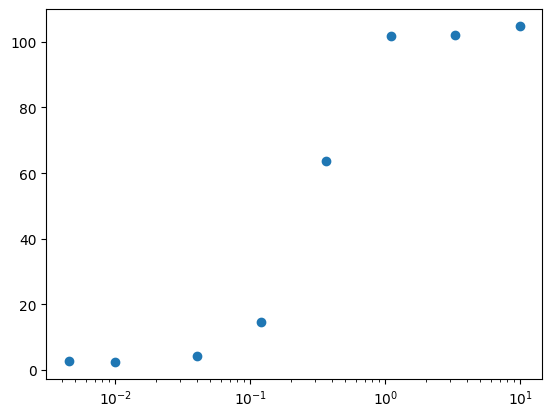

In [ ]:
Conc = Data.Conc.values
Resp = Data.Eff.values
plt.semilogx(Conc, Resp, 'o')

Fit the PD model to the given experimental data. You are trying to minimize least squares by changing IC50, E_max, and Hill_Coeff

In [ ]:
result_ENS = PDModel.fit(Resp/100, params, Conc=Conc)
ENS_Params = dict({result_ENS.params['E_max'].name:result_ENS.params['E_max'].value, result_ENS.params['IC50'].name: result_ENS.params['IC50'].value, result_ENS.params['Hill_Coeff'].name: result_ENS.params['Hill_Coeff'].value})

E_max is close to 1 as expected, IC50 is 0.27, Hill coefficient is 2.3

In [ ]:
ENS_Params

{'E_max': 0.9999999999873523,
 'IC50': 0.2718002303186362,
 'Hill_Coeff': 2.3044854687369707}

Print full results from fitting PD model
- R squared is 0.99, which is very close to 1

In [ ]:
result_ENS

Plot the fitted PD model over the experimental data

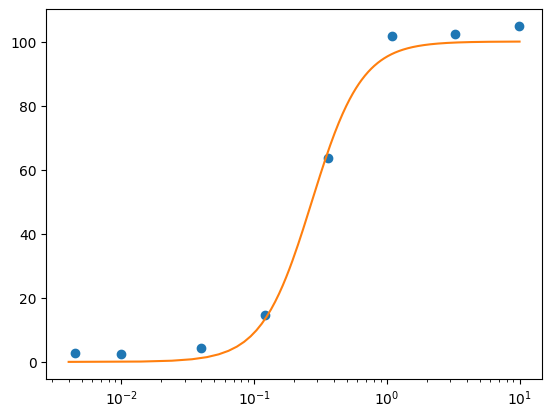

In [ ]:
plt.semilogx(Conc, Resp, 'o')
plt.plot(np.linspace(0.004, 10, 1000), PDModel.eval(result_ENS.params, Conc = np.linspace(0.004, 10, 1000))*100, '-')
